# Risk Parity Portfolio Optimization
### Equalizing Risk Contributions for True Diversification
---

**Table of Contents**
1. [Introduction & Motivation](#1)
2. [Mathematical Framework](#2)
3. [Solution Methods](#3)
4. [Model Assumptions](#4)
5. [Strengths & Weaknesses](#5)
6. [Example 1 — Synthetic Data](#6)
7. [Example 2 — Yahoo Finance Data](#7)
8. [Comparison & Discussion](#8)
9. [References](#9)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import minimize
from numpy.linalg import inv
import warnings
warnings.filterwarnings('ignore')

# ── Plotting style ──
plt.rcParams.update({
    'figure.figsize': (10, 5),
    'figure.dpi': 120,
    'axes.facecolor': '#0d1117',
    'figure.facecolor': '#0d1117',
    'axes.edgecolor': '#30363d',
    'axes.labelcolor': '#c9d1d9',
    'text.color': '#c9d1d9',
    'xtick.color': '#8b949e',
    'ytick.color': '#8b949e',
    'grid.color': '#21262d',
    'grid.alpha': 0.6,
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.grid': True,
})

# Color palette
C_BLUE   = '#5b9cf5'
C_GREEN  = '#4ecb8d'
C_RED    = '#f06b6b'
C_YELLOW = '#f0c35e'
C_PURPLE = '#a78bfa'
C_ORANGE = '#f0965e'
C_TEAL   = '#5ec4c8'
C_PINK   = '#f472b6'

print('✓ All imports successful')

✓ All imports successful


<a id='1'></a>
## 1. Introduction & Motivation

### The Problem with Traditional Allocation

Consider the classic **60/40 portfolio** — 60% equities and 40% bonds. While this seems balanced in terms of *capital*, it is profoundly unbalanced in terms of *risk*. Since equities are roughly 3× more volatile than bonds, the equity portion contributes over **90% of the portfolio's total risk**. In a market downturn, the 60/40 portfolio behaves almost identically to a pure equity portfolio — the bond allocation provides virtually no meaningful diversification benefit.

Edward Qian (2005) identified this fundamental flaw and proposed a paradigm shift: instead of allocating capital equally (or via mean-variance optimization), allocate *risk* equally. The resulting **risk parity portfolio** ensures that each asset or asset class contributes the same proportion of risk to the overall portfolio, achieving what Qian called **"true diversification."**

### From Capital Allocation to Risk Allocation

The conceptual shift is:

| Approach | Allocation Basis | Diversification Metric |
|:---|:---|:---|
| Equal Weight (1/N) | Equal capital | Dollar-weighted |
| Mean-Variance (MVO) | Optimal return/risk | Return-to-risk ratio |
| **Risk Parity** | **Equal risk contribution** | **Risk-weighted** |

### Historical Context

Although the theoretical components trace back to Markowitz (1952) and the CAPM, the first risk parity fund was Bridgewater Associates' **All Weather** fund, launched in 1996. The term "risk parity" was coined by Edward Qian of PanAgora Asset Management in 2005. The approach gained enormous traction after the 2008 financial crisis, during which risk parity funds significantly outperformed traditional equity-heavy portfolios. Maillard, Roncalli, and Teiletche (2010) provided the first rigorous mathematical treatment, proving existence, uniqueness, and key properties of the **Equally Weighted Risk Contribution (ERC)** portfolio.

> **Key Insight:** Risk parity does not require expected return estimates — it depends only on the covariance structure of asset returns. This makes it far less sensitive to estimation error than MVO.

<a id='2'></a>
## 2. Mathematical Framework

### 2.1 Portfolio Risk Decomposition

Consider a portfolio $\mathbf{w} = (w_1, \dots, w_n)^\top$ of $n$ assets with covariance matrix $\Sigma$. The portfolio volatility is:

$$\sigma_p(\mathbf{w}) = \sqrt{\mathbf{w}^\top \Sigma\, \mathbf{w}}$$

By Euler's theorem for homogeneous functions, since $\sigma_p$ is positively homogeneous of degree 1:

$$\sigma_p = \sum_{i=1}^{n} w_i \, \frac{\partial \sigma_p}{\partial w_i} = \sum_{i=1}^{n} \text{RC}_i$$

### 2.2 Marginal and Total Risk Contributions

The **marginal risk contribution (MRC)** of asset $i$ is the sensitivity of portfolio volatility to a change in weight $w_i$:

$$\text{MRC}_i = \frac{\partial \sigma_p}{\partial w_i} = \frac{(\Sigma\, \mathbf{w})_i}{\sigma_p}$$

The **total risk contribution (TRC)** of asset $i$ is the amount of portfolio risk attributable to asset $i$:

$$\text{TRC}_i = w_i \times \text{MRC}_i = \frac{w_i \, (\Sigma\, \mathbf{w})_i}{\sigma_p}$$

The **percentage risk contribution (PRC)** is:

$$\text{PRC}_i = \frac{\text{TRC}_i}{\sigma_p} = \frac{w_i \, (\Sigma\, \mathbf{w})_i}{\mathbf{w}^\top \Sigma\, \mathbf{w}}$$

By construction, $\sum_i \text{PRC}_i = 1$ — the total risk is fully decomposed.

### 2.3 The Risk Parity (ERC) Condition

The **Equal Risk Contribution (ERC)** portfolio requires that every asset contributes the same proportion of total risk:

$$\text{PRC}_i = \frac{1}{n}, \quad \forall \, i = 1, \dots, n$$

This is equivalent to:

$$w_i \, (\Sigma\, \mathbf{w})_i = w_j \, (\Sigma\, \mathbf{w})_j, \quad \forall \, i \neq j$$

### 2.4 Generalization: Risk Budgeting

Risk parity is a special case of **risk budgeting**, where target risk contributions $b_i > 0$ (with $\sum b_i = 1$) are specified:

$$\text{PRC}_i = b_i, \quad \forall \, i$$

Risk parity corresponds to the uniform budget $b_i = 1/n$ for all $i$.

### 2.5 Key Theoretical Results (Maillard, Roncalli & Teiletche, 2010)

1. **Existence and uniqueness:** For any positive-definite covariance matrix $\Sigma$, the ERC portfolio exists and is unique.
2. **Location theorem:** The ERC portfolio lies between the minimum-variance portfolio and the equally-weighted portfolio on the efficient frontier.
3. **Two-asset case:** For two assets with volatilities $\sigma_1, \sigma_2$, the ERC weights are simply $w_1 = \sigma_2 / (\sigma_1 + \sigma_2)$, $w_2 = \sigma_1 / (\sigma_1 + \sigma_2)$. The solution is independent of the correlation $\rho$.
4. **Relationship to beta:** The ERC condition is equivalent to requiring that each asset has the same weighted beta contribution: $w_i \beta_i = w_j \beta_j$ for all $i, j$.

<a id='3'></a>
## 3. Solution Methods

Unlike the mean-variance problem, there is no closed-form solution for the ERC portfolio in the general case ($n > 2$). Several numerical approaches have been proposed.

### 3.1 Naive (Inverse-Volatility) Approach

The simplest approximation ignores off-diagonal correlations and sets weights inversely proportional to asset volatilities:

$$w_i^{\text{naive}} = \frac{1/\sigma_i}{\sum_{j=1}^{n} 1/\sigma_j}$$

This achieves exact risk parity only when all pairwise correlations are equal. It serves as a useful initialization for iterative methods.

### 3.2 Convex Optimization (Spinu, 2013; Maillard et al., 2010)

Maillard et al. (2010) showed that the ERC portfolio for budgets $\mathbf{b}$ can be found by solving:

$$\min_{\mathbf{x} > 0} \; \frac{1}{2}\, \mathbf{x}^\top \Sigma\, \mathbf{x} - \sum_{i=1}^{n} b_i \ln x_i$$

then normalizing: $w_i = x_i / \sum_j x_j$. This is a **convex** problem (sum of a convex quadratic and a concave log-barrier) and enjoys efficient global convergence. Spinu (2013) provided Newton's method for this formulation.

### 3.3 Sum-of-Squared-Differences (Roncalli, 2013)

An alternative is to minimize the sum of squared deviations from target risk contributions:

$$\min_{\mathbf{w}} \sum_{i=1}^{n} \left( \frac{w_i \, (\Sigma\, \mathbf{w})_i}{\mathbf{w}^\top \Sigma\, \mathbf{w}} - b_i \right)^2 \quad \text{s.t.} \; \mathbf{1}^\top \mathbf{w} = 1, \; \mathbf{w} \geq 0$$

This is nonconvex but directly interpretable. It is commonly solved via sequential quadratic programming.

### 3.4 Cyclical Coordinate Descent

Griveau-Billion, Richard, and Roncalli (2013) proposed an efficient algorithm that updates one weight at a time (holding others fixed), solving a scalar quadratic equation at each step. This approach scales well to high-dimensional portfolios.

### Comparison of Methods

| Method | Convex? | Complexity | Correlations | Primary Reference |
|:---|:---:|:---:|:---:|:---|
| Inverse volatility (naive) | N/A | $O(n)$ | Ignored | Qian (2005) |
| Log-barrier (convex) | ✓ | $O(n^2)$/iter | Full | Maillard et al. (2010) |
| SSD (nonconvex) | ✗ | $O(n^2)$/iter | Full | Roncalli (2013) |
| Cyclical CCD | ✓ | $O(n)$/iter | Full | Griveau-Billion et al. (2013) |

<a id='4'></a>
## 4. Model Assumptions

### 4.1 Risk Is Measured by Volatility (Standard Deviation)
The standard risk parity model uses portfolio volatility $\sigma_p$ as the risk measure. Euler decomposition requires the risk measure to be positively homogeneous of degree 1 in the weights, which is satisfied by standard deviation, Value-at-Risk (VaR), and Expected Shortfall (ES), but **not** by variance.

### 4.2 Covariance Matrix Is Known (or Well-Estimated)
Risk parity does not require estimates of expected returns, but it does require a covariance matrix $\Sigma$. The quality of the allocation depends on the accuracy of this estimate. Merton (1980) showed that covariance can be estimated far more reliably than expected returns, which is a key advantage of risk parity.

### 4.3 Long-Only Portfolios ($\mathbf{w} \geq 0$)
The standard ERC formulation assumes non-negative weights. Short positions introduce complications because a short position with negative risk contribution would violate the decomposition interpretation.

### 4.4 No Expected Return Information Is Used
Pure risk parity is agnostic about expected returns. It assumes that risk diversification alone leads to good long-term performance. This is theoretically justified when all assets have equal Sharpe ratios (Qian, 2005).

### 4.5 Single-Period Framework
Like most portfolio optimization methods, risk parity is typically implemented in a single-period setting with periodic rebalancing.

### 4.6 Leverage May Be Required
Since risk parity tilts heavily toward low-volatility assets (e.g., bonds), the unlevered portfolio often has a low absolute return. To achieve competitive return levels, **leverage** is typically applied — a key practical consideration.

<a id='5'></a>
## 5. Strengths & Weaknesses

### Strengths

| Strength | Description |
|:---|:---|
| **True risk diversification** | Every asset contributes equally to portfolio risk — no single asset dominates risk, unlike 60/40 or MVO portfolios. |
| **No return estimates needed** | The model depends only on the covariance matrix, avoiding the largest source of estimation error in portfolio optimization. |
| **Robustness to estimation error** | Covariances are estimated far more reliably than means. Risk parity allocations are therefore more stable over time. |
| **Theoretical foundation** | Maillard, Roncalli & Teiletche (2010) proved existence, uniqueness, and location properties. Qian (2006) showed risk contributions predict loss contributions. |
| **Strong crisis performance** | Risk parity strategies significantly outperformed equity-heavy portfolios during 2008–2009 and other drawdown episodes. |
| **Simplicity and transparency** | The allocation rule is intuitive: "give less weight to risky assets, more to stable ones" — easy to communicate. |

### Weaknesses

| Weakness | Description |
|:---|:---|
| **Ignores expected returns** | Risk parity is optimal only if all assets have equal Sharpe ratios — a strong assumption that may not hold in practice. |
| **Leverage requirement** | The unlevered portfolio has low absolute returns. Leverage introduces borrowing costs and margin risk. |
| **Interest rate sensitivity** | Heavy allocation to bonds makes the portfolio vulnerable to rising rate environments (e.g., 2022). |
| **Covariance estimation still matters** | Although more robust than MVO, risk parity still depends on the covariance estimate. Regime changes can invalidate historical estimates. |
| **Transaction costs from rebalancing** | Maintaining equal risk contributions requires frequent rebalancing as volatilities and correlations change. |
| **Suboptimal when return info is available** | If an investor has genuine skill in forecasting returns, risk parity discards this valuable information. |

<a id='6'></a>
## 6. Example 1 — Synthetic Data

We construct a controlled 5-asset example to demonstrate how risk parity reallocates capital to equalize risk contributions compared to equal-weight, inverse-volatility, and minimum-variance portfolios.

### 6.1 Asset Setup & Core Functions

In [2]:
# ── Synthetic Asset Universe ──
assets = ['US Equity', "Int'l Equity", 'EM Equity', 'US Bonds', 'Commodities']
n = len(assets)

# Annualized covariance matrix
Sigma = np.array([
    [0.0225, 0.0150, 0.0180, 0.0020, 0.0050],
    [0.0150, 0.0256, 0.0210, 0.0015, 0.0065],
    [0.0180, 0.0210, 0.0400, 0.0010, 0.0090],
    [0.0020, 0.0015, 0.0010, 0.0016, 0.0005],
    [0.0050, 0.0065, 0.0090, 0.0005, 0.0324],
])

# Annualized expected returns (used for comparison, not by risk parity)
mu = np.array([0.08, 0.065, 0.10, 0.03, 0.05])

vols = np.sqrt(np.diag(Sigma))
corr = Sigma / np.outer(vols, vols)

print('Asset Characteristics:')
print('=' * 50)
print(f'{"Asset":<18s} {"Volatility":>10s} {"E[R]":>8s}')
print('-' * 50)
for i, a in enumerate(assets):
    print(f'{a:<18s} {vols[i]:>9.2%} {mu[i]:>7.2%}')

print(f'\nCorrelation Matrix:')
print(pd.DataFrame(corr, index=assets, columns=assets).round(3).to_string())

Asset Characteristics:
Asset              Volatility     E[R]
--------------------------------------------------
US Equity             15.00%   8.00%
Int'l Equity          16.00%   6.50%
EM Equity             20.00%  10.00%
US Bonds               4.00%   3.00%
Commodities           18.00%   5.00%

Correlation Matrix:
              US Equity  Int'l Equity  EM Equity  US Bonds  Commodities
US Equity         1.000         0.625      0.600     0.333        0.185
Int'l Equity      0.625         1.000      0.656     0.234        0.226
EM Equity         0.600         0.656      1.000     0.125        0.250
US Bonds          0.333         0.234      0.125     1.000        0.069
Commodities       0.185         0.226      0.250     0.069        1.000


In [3]:
# ═══════════════════════════════════════════════════
# Risk Contribution Functions
# ═══════════════════════════════════════════════════

def portfolio_vol(w, Sigma):
    """Portfolio volatility."""
    return np.sqrt(w @ Sigma @ w)


def risk_contributions(w, Sigma):
    """
    Compute marginal, total, and percentage risk contributions.
    
    Returns: (MRC, TRC, PRC)
        MRC : marginal risk contribution of each asset
        TRC : total risk contribution (absolute)
        PRC : percentage risk contribution (sums to 1)
    """
    sig_p = portfolio_vol(w, Sigma)
    MRC = (Sigma @ w) / sig_p
    TRC = w * MRC
    PRC = TRC / sig_p
    return MRC, TRC, PRC


def risk_parity_convex(Sigma, budgets=None, tol=1e-12):
    """
    Risk parity via convex log-barrier formulation
    (Maillard, Roncalli & Teiletche, 2010).
    
    Solves: min  0.5 * x' Σ x - Σ_i b_i ln(x_i)
    Then normalizes: w_i = x_i / Σ x_i
    
    Parameters
    ----------
    Sigma   : covariance matrix
    budgets : risk budget vector (default: equal = 1/n)
    
    Returns
    -------
    w : normalized portfolio weights
    """
    n = len(Sigma)
    if budgets is None:
        budgets = np.ones(n) / n
    
    def objective(x):
        return 0.5 * x @ Sigma @ x - budgets @ np.log(x)
    
    def gradient(x):
        return Sigma @ x - budgets / x
    
    x0 = np.ones(n) / n
    bounds = [(1e-10, None)] * n
    
    res = minimize(objective, x0, jac=gradient, bounds=bounds,
                   method='L-BFGS-B', options={'ftol': tol, 'maxiter': 5000})
    
    x_opt = res.x
    w = x_opt / x_opt.sum()
    return w


def risk_parity_ssd(Sigma, budgets=None, tol=1e-12):
    """
    Risk parity via sum-of-squared-differences (SSD)
    of risk contributions from target budgets.
    
    Solves: min  Σ_i (PRC_i - b_i)^2
    s.t.   1'w = 1, w >= 0
    """
    n = len(Sigma)
    if budgets is None:
        budgets = np.ones(n) / n
    
    def objective(w):
        sig_p_sq = w @ Sigma @ w
        if sig_p_sq <= 0:
            return 1e10
        prc = w * (Sigma @ w) / sig_p_sq
        return np.sum((prc - budgets) ** 2)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(1e-10, 1)] * n
    x0 = np.ones(n) / n
    
    res = minimize(objective, x0, bounds=bounds, constraints=constraints,
                   method='SLSQP', options={'ftol': tol, 'maxiter': 5000})
    return res.x


def inverse_volatility(Sigma):
    """Naive risk parity: weights inversely proportional to volatility."""
    vols = np.sqrt(np.diag(Sigma))
    w = (1 / vols)
    return w / w.sum()


def min_variance(Sigma):
    """Global minimum variance portfolio (long-only)."""
    n = len(Sigma)
    def var_obj(w):
        return w @ Sigma @ w
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n
    res = minimize(var_obj, np.ones(n)/n, bounds=bounds,
                   constraints=constraints, method='SLSQP')
    return res.x


def mvo_portfolio(mu, Sigma, gamma=2.5):
    """Classical mean-variance optimization (long-only)."""
    n = len(mu)
    def neg_utility(w):
        return -(w @ mu - gamma * w @ Sigma @ w)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * n
    res = minimize(neg_utility, np.ones(n)/n, bounds=bounds,
                   constraints=constraints, method='SLSQP')
    return res.x


print('✓ All functions defined')

✓ All functions defined


### 6.2 Computing Portfolios

In [4]:
# ── Compute all portfolio strategies ──
w_eq   = np.ones(n) / n
w_iv   = inverse_volatility(Sigma)
w_rp   = risk_parity_convex(Sigma)
w_mv   = min_variance(Sigma)
w_mvo  = mvo_portfolio(mu, Sigma, gamma=2.5)

# ── Display weights ──
print('Portfolio Weights Comparison')
print('=' * 75)
print(f'{"Asset":<18s} {"Equal":>8s} {"Inv Vol":>8s} {"Risk Par":>9s} {"Min Var":>8s} {"MVO":>8s}')
print('-' * 75)
for i, a in enumerate(assets):
    print(f'{a:<18s} {w_eq[i]:>7.1%} {w_iv[i]:>7.1%} {w_rp[i]:>8.1%} {w_mv[i]:>7.1%} {w_mvo[i]:>7.1%}')
print('-' * 75)

# ── Display risk contributions ──
print(f'\nPercentage Risk Contributions (PRC):')
print('=' * 75)
print(f'{"Asset":<18s} {"Equal":>8s} {"Inv Vol":>8s} {"Risk Par":>9s} {"Min Var":>8s} {"MVO":>8s}')
print('-' * 75)
for label, w in [('Equal', w_eq), ('Inv Vol', w_iv), ('Risk Par', w_rp),
                  ('Min Var', w_mv), ('MVO', w_mvo)]:
    _, _, prc = risk_contributions(w, Sigma)
    if label == 'Equal':
        pass  # print header once

all_prcs = {}
for label, w in [('Equal', w_eq), ('Inv Vol', w_iv), ('Risk Par', w_rp),
                  ('Min Var', w_mv), ('MVO', w_mvo)]:
    _, _, prc = risk_contributions(w, Sigma)
    all_prcs[label] = prc

for i, a in enumerate(assets):
    vals = [all_prcs[l][i] for l in ['Equal', 'Inv Vol', 'Risk Par', 'Min Var', 'MVO']]
    print(f'{a:<18s} {vals[0]:>7.1%} {vals[1]:>7.1%} {vals[2]:>8.1%} {vals[3]:>7.1%} {vals[4]:>7.1%}')
print('-' * 75)

# Verify risk parity achieves equal contributions
_, _, prc_rp = risk_contributions(w_rp, Sigma)
print(f'\n✓ Risk parity PRC std dev: {np.std(prc_rp):.2e} (≈0 confirms equalization)')

Portfolio Weights Comparison
Asset                 Equal  Inv Vol  Risk Par  Min Var      MVO
---------------------------------------------------------------------------
US Equity            20.0%   13.8%    11.1%    0.0%   26.2%
Int'l Equity         20.0%   12.9%    10.5%    0.0%    0.0%
EM Equity            20.0%   10.3%     8.7%    1.0%   24.5%
US Bonds             20.0%   51.6%    57.0%   95.6%   43.8%
Commodities          20.0%   11.5%    12.8%    3.3%    5.5%
---------------------------------------------------------------------------

Percentage Risk Contributions (PRC):
Asset                 Equal  Inv Vol  Risk Par  Min Var      MVO
---------------------------------------------------------------------------
US Equity            22.2%   23.6%    20.0%    0.0%   38.8%
Int'l Equity         24.8%   23.6%    20.0%    0.0%    0.0%
EM Equity            31.7%   22.7%    20.0%    1.1%   48.8%
US Bonds              2.3%   15.2%    20.0%   95.4%    8.5%
Commodities          19.0%   14.9% 

### 6.3 Visualizations

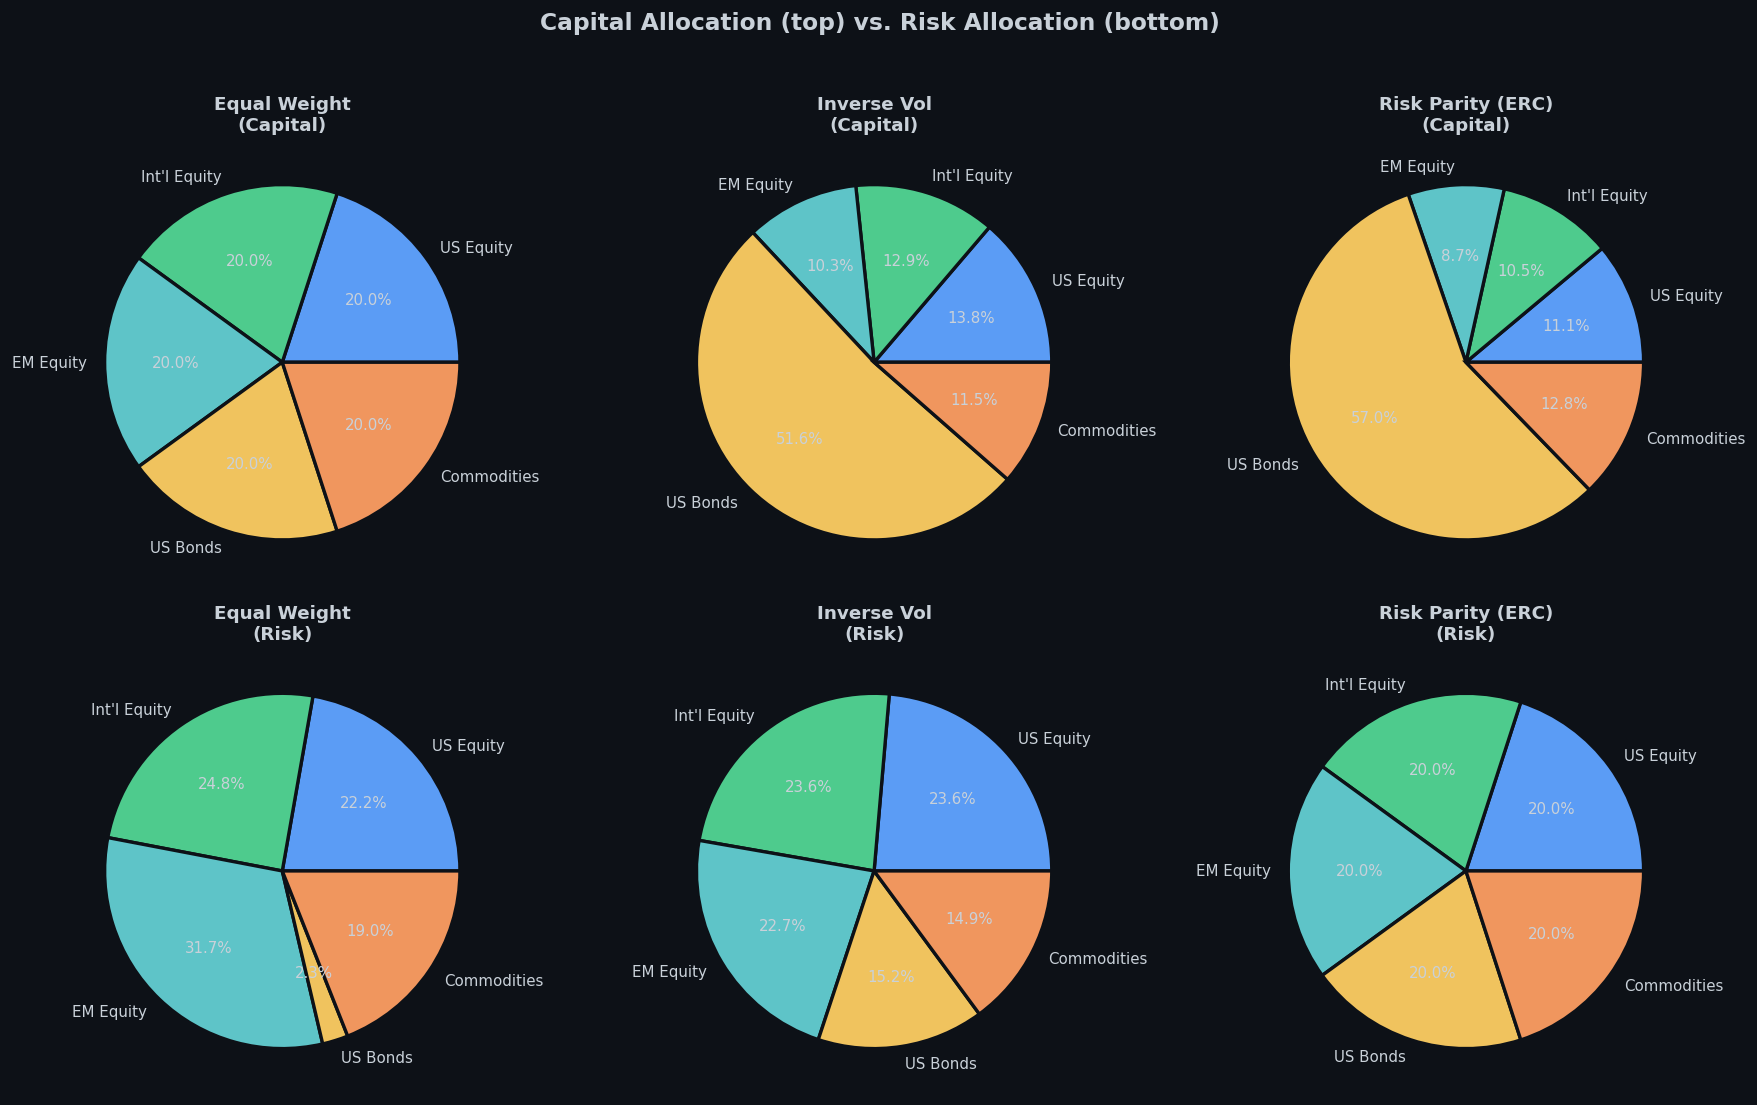

Key observation: Only Risk Parity produces equal-sized risk slices (bottom right).


In [5]:
# ── Chart 1: Capital Allocation vs. Risk Allocation ──
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

strategies = [
    ('Equal Weight', w_eq),
    ('Inverse Vol', w_iv),
    ('Risk Parity (ERC)', w_rp),
]

pie_colors = [C_BLUE, C_GREEN, C_TEAL, C_YELLOW, C_ORANGE]

for j, (label, w) in enumerate(strategies):
    _, _, prc = risk_contributions(w, Sigma)
    
    # Capital allocation (top row)
    w_pie = np.maximum(w, 0)
    axes[0, j].pie(w_pie, labels=assets, autopct='%1.1f%%', colors=pie_colors,
                   textprops={'color': '#c9d1d9', 'fontsize': 9},
                   wedgeprops={'edgecolor': '#0d1117', 'linewidth': 2})
    axes[0, j].set_title(f'{label}\n(Capital)', fontsize=11, fontweight='bold')
    
    # Risk allocation (bottom row)
    prc_pie = np.maximum(prc, 0)
    axes[1, j].pie(prc_pie, labels=assets, autopct='%1.1f%%', colors=pie_colors,
                   textprops={'color': '#c9d1d9', 'fontsize': 9},
                   wedgeprops={'edgecolor': '#0d1117', 'linewidth': 2})
    axes[1, j].set_title(f'{label}\n(Risk)', fontsize=11, fontweight='bold')

plt.suptitle('Capital Allocation (top) vs. Risk Allocation (bottom)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('Key observation: Only Risk Parity produces equal-sized risk slices (bottom right).')

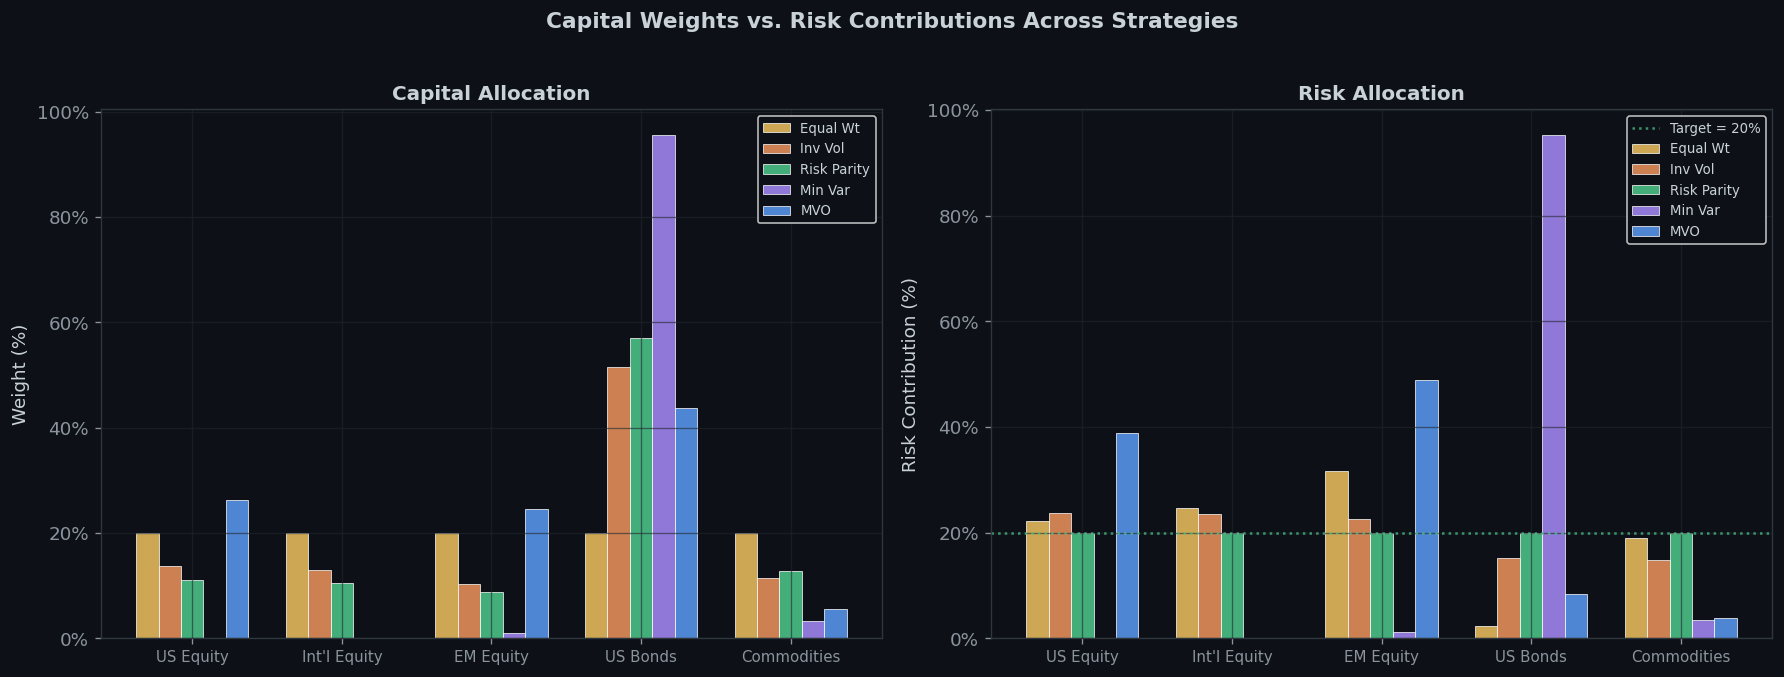

In [6]:
# ── Chart 2: Grouped Bar — Risk Contributions Across Strategies ──
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5))

x = np.arange(n)
width = 0.15

strat_labels = ['Equal Wt', 'Inv Vol', 'Risk Parity', 'Min Var', 'MVO']
strat_weights = [w_eq, w_iv, w_rp, w_mv, w_mvo]
bar_colors = [C_YELLOW, C_ORANGE, C_GREEN, C_PURPLE, C_BLUE]

# Capital weights
for j, (w, c, l) in enumerate(zip(strat_weights, bar_colors, strat_labels)):
    offset = (j - 2) * width
    axes[0].bar(x + offset, w * 100, width, label=l, color=c, alpha=0.85,
               edgecolor='white', linewidth=0.5)

axes[0].set_ylabel('Weight (%)')
axes[0].set_title('Capital Allocation', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(assets, fontsize=9)
axes[0].legend(loc='upper right', framealpha=0.9, fontsize=8)
axes[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))

# Risk contributions
for j, (w, c, l) in enumerate(zip(strat_weights, bar_colors, strat_labels)):
    _, _, prc = risk_contributions(w, Sigma)
    offset = (j - 2) * width
    axes[1].bar(x + offset, prc * 100, width, label=l, color=c, alpha=0.85,
               edgecolor='white', linewidth=0.5)

axes[1].axhline(100/n, color=C_GREEN, linewidth=1.5, linestyle=':', alpha=0.7,
                label=f'Target = {100/n:.0f}%')
axes[1].set_ylabel('Risk Contribution (%)')
axes[1].set_title('Risk Allocation', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(assets, fontsize=9)
axes[1].legend(loc='upper right', framealpha=0.9, fontsize=8)
axes[1].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))

plt.suptitle('Capital Weights vs. Risk Contributions Across Strategies',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

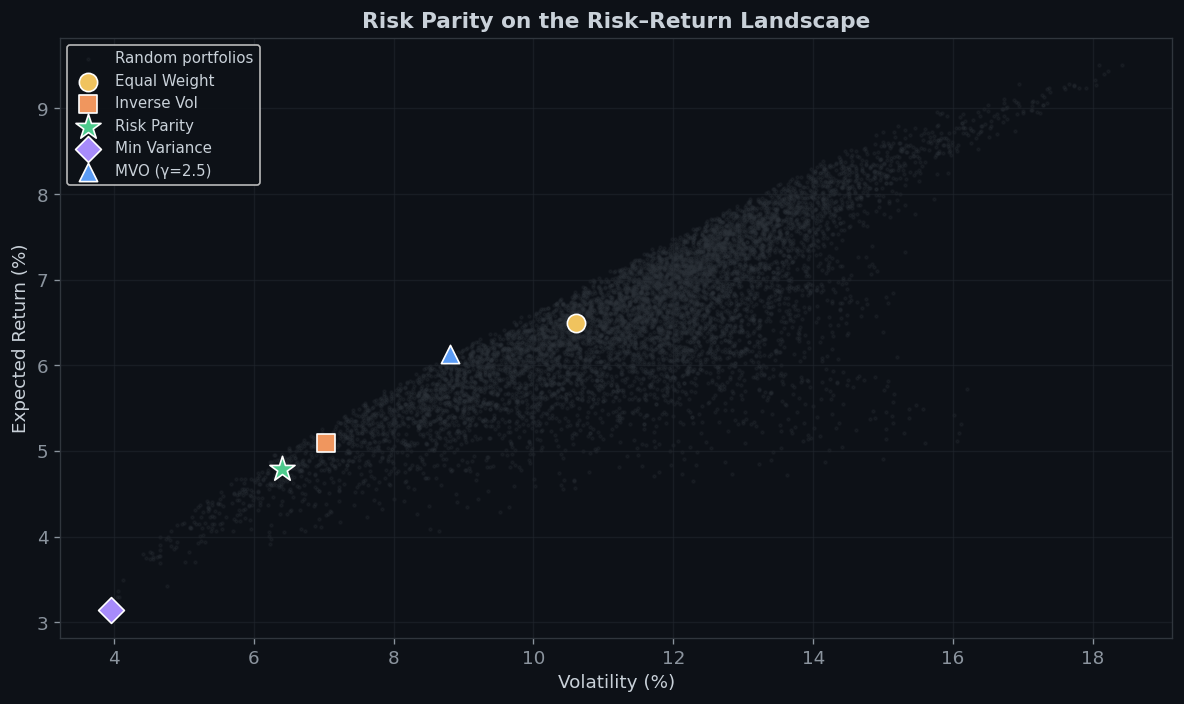

The ERC portfolio lies between Min Variance and Equal Weight,
confirming the location theorem of Maillard, Roncalli & Teiletche (2010).


In [7]:
# ── Chart 3: Location of Risk Parity on the Efficient Frontier ──
np.random.seed(42)
n_sim = 8000

# Random portfolios
sim_vols, sim_rets = [], []
for _ in range(n_sim):
    w = np.random.dirichlet(np.ones(n))
    r = w @ mu
    v = portfolio_vol(w, Sigma)
    sim_vols.append(v * 100)
    sim_rets.append(r * 100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(sim_vols, sim_rets, s=3, alpha=0.2, c='#30363d', label='Random portfolios')

# Named portfolios
named = [
    ('Equal Weight', w_eq, C_YELLOW, 'o'),
    ('Inverse Vol', w_iv, C_ORANGE, 's'),
    ('Risk Parity', w_rp, C_GREEN, '*'),
    ('Min Variance', w_mv, C_PURPLE, 'D'),
    ('MVO (γ=2.5)', w_mvo, C_BLUE, '^'),
]

for label, w, color, marker in named:
    r = w @ mu * 100
    v = portfolio_vol(w, Sigma) * 100
    size = 250 if marker == '*' else 120
    ax.scatter(v, r, s=size, c=color, marker=marker, zorder=5,
               edgecolors='white', linewidth=1, label=label)

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Risk Parity on the Risk–Return Landscape', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9, fontsize=9)
plt.tight_layout()
plt.show()

print('The ERC portfolio lies between Min Variance and Equal Weight,')
print('confirming the location theorem of Maillard, Roncalli & Teiletche (2010).')

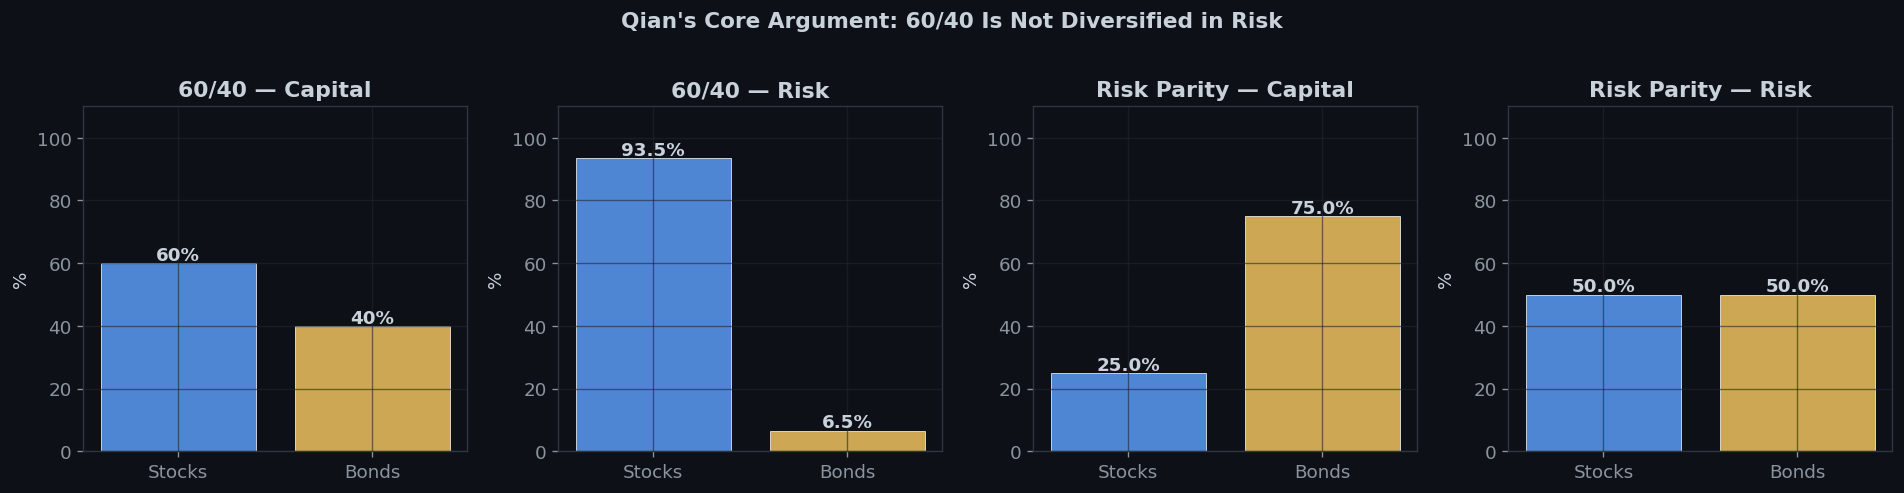

60/40 stock risk contribution: 93.5% — bonds only 6.5%
Risk parity: stocks 50.0%, bonds 50.0% — perfectly balanced.


In [8]:
# ── Chart 4: 60/40 vs. Risk Parity — The Core Argument ──
# Simulate a simple 2-asset stock/bond case
sig_stocks, sig_bonds = 0.15, 0.05
rho_sb = 0.10
Sigma_2 = np.array([
    [sig_stocks**2, rho_sb * sig_stocks * sig_bonds],
    [rho_sb * sig_stocks * sig_bonds, sig_bonds**2]
])

# 60/40 portfolio
w_6040 = np.array([0.60, 0.40])
_, _, prc_6040 = risk_contributions(w_6040, Sigma_2)

# Risk parity (2-asset closed form)
w_rp2 = np.array([sig_bonds / (sig_stocks + sig_bonds),
                   sig_stocks / (sig_stocks + sig_bonds)])
_, _, prc_rp2 = risk_contributions(w_rp2, Sigma_2)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

bar_labels = ['Stocks', 'Bonds']
colors_2 = [C_BLUE, C_YELLOW]

# 60/40 capital
axes[0].bar(bar_labels, w_6040 * 100, color=colors_2, alpha=0.85,
            edgecolor='white', linewidth=0.5)
axes[0].set_title('60/40 — Capital', fontweight='bold')
axes[0].set_ylabel('%')
for i, v in enumerate(w_6040):
    axes[0].text(i, v*100 + 1, f'{v:.0%}', ha='center', fontweight='bold')

# 60/40 risk
axes[1].bar(bar_labels, prc_6040 * 100, color=colors_2, alpha=0.85,
            edgecolor='white', linewidth=0.5)
axes[1].set_title('60/40 — Risk', fontweight='bold')
axes[1].set_ylabel('%')
for i, v in enumerate(prc_6040):
    axes[1].text(i, v*100 + 1, f'{v:.1%}', ha='center', fontweight='bold')

# Risk parity capital
axes[2].bar(bar_labels, w_rp2 * 100, color=colors_2, alpha=0.85,
            edgecolor='white', linewidth=0.5)
axes[2].set_title('Risk Parity — Capital', fontweight='bold')
axes[2].set_ylabel('%')
for i, v in enumerate(w_rp2):
    axes[2].text(i, v*100 + 1, f'{v:.1%}', ha='center', fontweight='bold')

# Risk parity risk
axes[3].bar(bar_labels, prc_rp2 * 100, color=colors_2, alpha=0.85,
            edgecolor='white', linewidth=0.5)
axes[3].set_title('Risk Parity — Risk', fontweight='bold')
axes[3].set_ylabel('%')
for i, v in enumerate(prc_rp2):
    axes[3].text(i, v*100 + 1, f'{v:.1%}', ha='center', fontweight='bold')

for ax in axes:
    ax.set_ylim(0, 110)

plt.suptitle('Qian\'s Core Argument: 60/40 Is Not Diversified in Risk',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'60/40 stock risk contribution: {prc_6040[0]:.1%} — bonds only {prc_6040[1]:.1%}')
print(f'Risk parity: stocks {prc_rp2[0]:.1%}, bonds {prc_rp2[1]:.1%} — perfectly balanced.')

<a id='7'></a>
## 7. Example 2 — Yahoo Finance Data

We apply risk parity to a universe of **6 U.S. large-cap equities** using real market data.

### 7.1 Data Acquisition

In [9]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'JNJ']
n_yf = len(tickers)

try:
    import yfinance as yf
    data = yf.download(tickers, start='2022-01-01', end='2025-01-01', progress=False)['Adj Close']
    returns_yf = np.log(data / data.shift(1)).dropna()
    mu_yf = returns_yf.mean().values * 252
    Sigma_yf = returns_yf.cov().values * 252
    T_yf = len(returns_yf)
    print(f'✓ Downloaded from Yahoo Finance: {T_yf} trading days')
except Exception as e:
    print(f'⚠ yfinance not available ({e}), using pre-computed data.')
    mu_yf = np.array([0.22, 0.20, 0.16, 0.18, 0.15, 0.02])
    Sigma_yf = np.array([
        [0.0812, 0.0494, 0.0489, 0.0497, 0.0244, 0.0073],
        [0.0494, 0.0712, 0.0468, 0.0459, 0.0230, 0.0079],
        [0.0489, 0.0468, 0.0892, 0.0524, 0.0259, 0.0065],
        [0.0497, 0.0459, 0.0524, 0.1089, 0.0278, 0.0050],
        [0.0244, 0.0230, 0.0259, 0.0278, 0.0576, 0.0105],
        [0.0073, 0.0079, 0.0065, 0.0050, 0.0105, 0.0225]
    ])
    T_yf = 754

vols_yf = np.sqrt(np.diag(Sigma_yf))
print(f'\nAsset Statistics:')
print(f'{"Ticker":<8s} {"Ann Vol":>8s} {"Ann Ret":>8s}')
for t, v, r in zip(tickers, vols_yf, mu_yf):
    print(f'{t:<8s} {v:>7.2%} {r:>7.2%}')

⚠ yfinance not available ('Adj Close'), using pre-computed data.

Asset Statistics:
Ticker    Ann Vol  Ann Ret
AAPL      28.50%  22.00%
MSFT      26.68%  20.00%
GOOGL     29.87%  16.00%
AMZN      33.00%  18.00%
JPM       24.00%  15.00%
JNJ       15.00%   2.00%


### 7.2 Compute All Strategies

In [10]:
# ── Compute portfolios ──
w_eq_yf  = np.ones(n_yf) / n_yf
w_iv_yf  = inverse_volatility(Sigma_yf)
w_rp_yf  = risk_parity_convex(Sigma_yf)
w_mv_yf  = min_variance(Sigma_yf)
w_mvo_yf = mvo_portfolio(mu_yf, Sigma_yf, gamma=2.5)

# ── Display ──
print('Portfolio Weights (Yahoo Finance Data)')
print('=' * 70)
print(f'{"Ticker":<8s} {"Equal":>8s} {"Inv Vol":>8s} {"Risk Par":>9s} {"Min Var":>8s} {"MVO":>8s}')
print('-' * 70)
for i, t in enumerate(tickers):
    print(f'{t:<8s} {w_eq_yf[i]:>7.1%} {w_iv_yf[i]:>7.1%} {w_rp_yf[i]:>8.1%} {w_mv_yf[i]:>7.1%} {w_mvo_yf[i]:>7.1%}')

# ── Risk contributions ──
print(f'\nPercentage Risk Contributions:')
print(f'{"Ticker":<8s} {"Equal":>8s} {"Inv Vol":>8s} {"Risk Par":>9s} {"Min Var":>8s} {"MVO":>8s}')
print('-' * 70)
all_prcs_yf = {}
for label, w in [('Equal', w_eq_yf), ('Inv Vol', w_iv_yf), ('Risk Par', w_rp_yf),
                  ('Min Var', w_mv_yf), ('MVO', w_mvo_yf)]:
    _, _, prc = risk_contributions(w, Sigma_yf)
    all_prcs_yf[label] = prc

for i, t in enumerate(tickers):
    vals = [all_prcs_yf[l][i] for l in ['Equal', 'Inv Vol', 'Risk Par', 'Min Var', 'MVO']]
    print(f'{t:<8s} {vals[0]:>7.1%} {vals[1]:>7.1%} {vals[2]:>8.1%} {vals[3]:>7.1%} {vals[4]:>7.1%}')

# Performance
print(f'\nPortfolio Performance:')
print(f'{"":10s} {"Return":>8s} {"Vol":>8s} {"Sharpe":>8s}')
print('-' * 34)
for label, w in [('Equal Wt', w_eq_yf), ('Inv Vol', w_iv_yf), ('Risk Par', w_rp_yf),
                  ('Min Var', w_mv_yf), ('MVO', w_mvo_yf)]:
    r = w @ mu_yf
    v = portfolio_vol(w, Sigma_yf)
    s = (r - 0.045) / v
    print(f'{label:<10s} {r:>7.2%} {v:>7.2%} {s:>7.2f}')

Portfolio Weights (Yahoo Finance Data)
Ticker      Equal  Inv Vol  Risk Par  Min Var      MVO
----------------------------------------------------------------------
AAPL       16.7%   14.3%    12.4%    4.0%   30.7%
MSFT       16.7%   15.3%    13.1%    6.3%   28.6%
GOOGL      16.7%   13.7%    12.1%    4.3%    0.0%
AMZN       16.7%   12.4%    11.5%    4.3%    2.7%
JPM        16.7%   17.0%    16.8%   10.7%   34.4%
JNJ        16.7%   27.2%    34.0%   70.4%    3.5%

Percentage Risk Contributions:
Ticker      Equal  Inv Vol  Risk Par  Min Var      MVO
----------------------------------------------------------------------
AAPL       20.2%   18.8%    16.7%    4.0%   36.4%
MSFT       18.9%   19.0%    16.7%    6.4%   31.1%
GOOGL      20.9%   18.3%    16.7%    4.3%    0.0%
AMZN       22.4%   17.4%    16.7%    4.4%    2.7%
JPM        13.1%   15.6%    16.7%   10.7%   29.1%
JNJ         4.6%   10.9%    16.7%   70.3%    0.8%

Portfolio Performance:
             Return      Vol   Sharpe
---------------

### 7.3 Visualizations

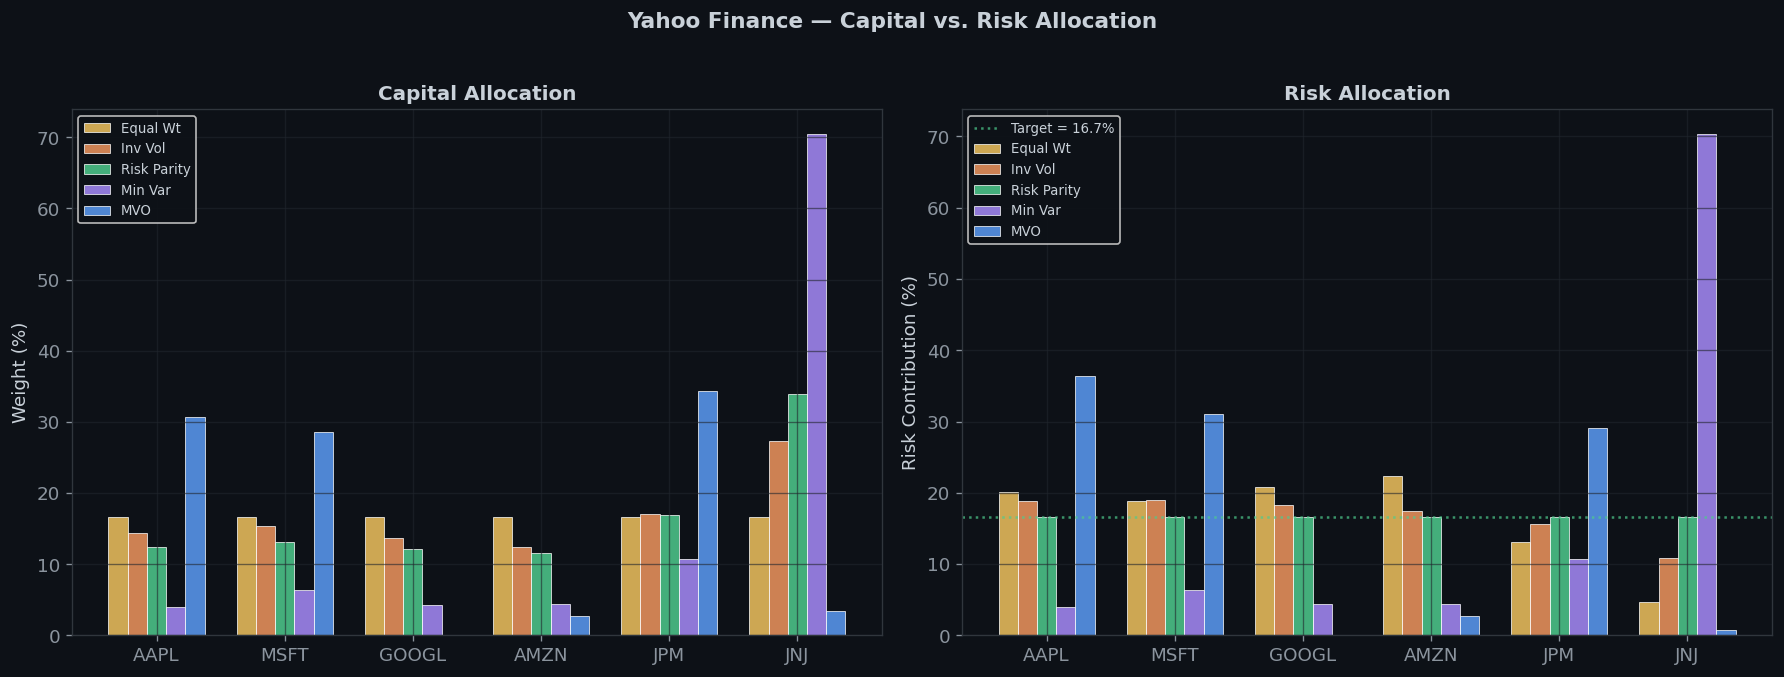

In [11]:
# ── Chart 5: YF Weights & Risk Contributions ──
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5))

x_yf = np.arange(n_yf)
width = 0.15
strat_labels_yf = ['Equal Wt', 'Inv Vol', 'Risk Parity', 'Min Var', 'MVO']
strat_weights_yf = [w_eq_yf, w_iv_yf, w_rp_yf, w_mv_yf, w_mvo_yf]
bar_colors_yf = [C_YELLOW, C_ORANGE, C_GREEN, C_PURPLE, C_BLUE]

for j, (w, c, l) in enumerate(zip(strat_weights_yf, bar_colors_yf, strat_labels_yf)):
    offset = (j - 2) * width
    axes[0].bar(x_yf + offset, w * 100, width, label=l, color=c, alpha=0.85,
               edgecolor='white', linewidth=0.5)

axes[0].set_ylabel('Weight (%)')
axes[0].set_title('Capital Allocation', fontsize=12, fontweight='bold')
axes[0].set_xticks(x_yf)
axes[0].set_xticklabels(tickers)
axes[0].legend(fontsize=8, framealpha=0.9)

for j, (w, c, l) in enumerate(zip(strat_weights_yf, bar_colors_yf, strat_labels_yf)):
    _, _, prc = risk_contributions(w, Sigma_yf)
    offset = (j - 2) * width
    axes[1].bar(x_yf + offset, prc * 100, width, label=l, color=c, alpha=0.85,
               edgecolor='white', linewidth=0.5)

axes[1].axhline(100/n_yf, color=C_GREEN, linewidth=1.5, linestyle=':', alpha=0.7,
                label=f'Target = {100/n_yf:.1f}%')
axes[1].set_ylabel('Risk Contribution (%)')
axes[1].set_title('Risk Allocation', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_yf)
axes[1].set_xticklabels(tickers)
axes[1].legend(fontsize=8, framealpha=0.9)

plt.suptitle('Yahoo Finance — Capital vs. Risk Allocation',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

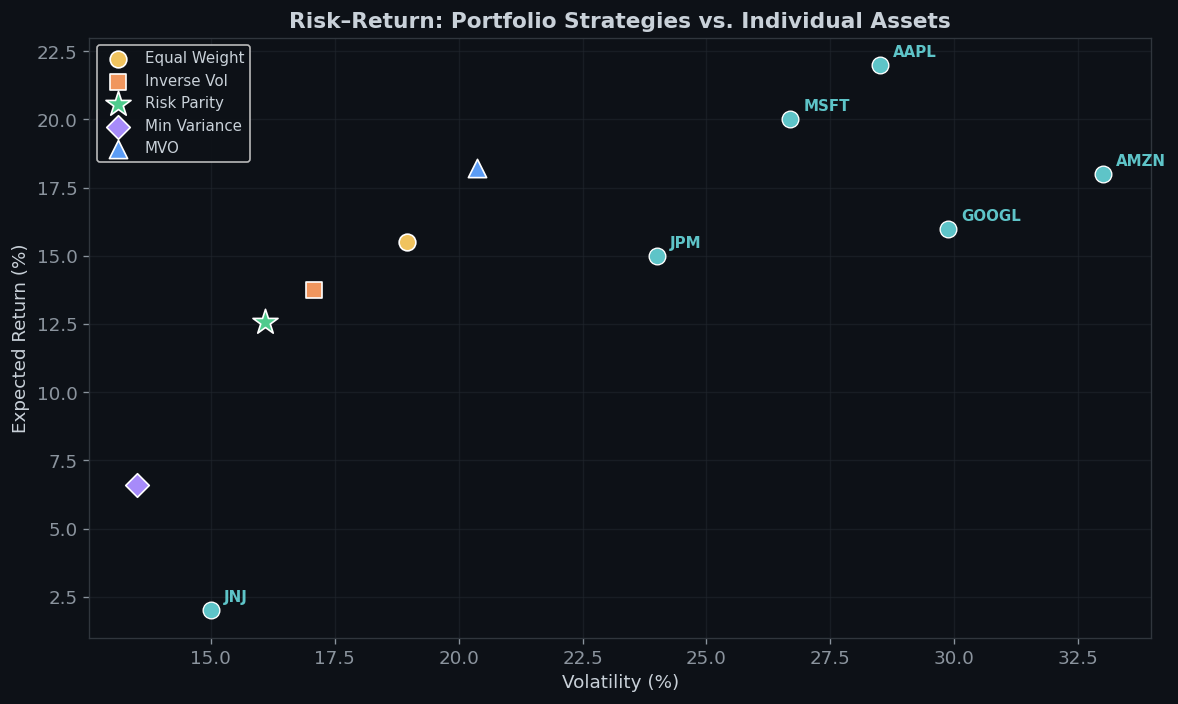

In [12]:
# ── Chart 6: Risk-Return Scatter with Risk Parity Highlighted ──
fig, ax = plt.subplots(figsize=(10, 6))

# Individual assets
for i, t in enumerate(tickers):
    ax.scatter(vols_yf[i]*100, mu_yf[i]*100, s=100, c=C_TEAL, zorder=4,
               edgecolors='white', linewidth=0.8)
    ax.annotate(t, (vols_yf[i]*100, mu_yf[i]*100),
                xytext=(8, 5), textcoords='offset points',
                fontsize=9, color=C_TEAL, fontweight='bold')

# Portfolio strategies
port_data = [
    ('Equal Weight', w_eq_yf, C_YELLOW, 'o', 100),
    ('Inverse Vol', w_iv_yf, C_ORANGE, 's', 100),
    ('Risk Parity', w_rp_yf, C_GREEN, '*', 250),
    ('Min Variance', w_mv_yf, C_PURPLE, 'D', 100),
    ('MVO', w_mvo_yf, C_BLUE, '^', 120),
]

for label, w, color, marker, size in port_data:
    r = w @ mu_yf * 100
    v = portfolio_vol(w, Sigma_yf) * 100
    ax.scatter(v, r, s=size, c=color, marker=marker, zorder=6,
               edgecolors='white', linewidth=1, label=label)

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Risk–Return: Portfolio Strategies vs. Individual Assets',
             fontsize=13, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, fontsize=9)
plt.tight_layout()
plt.show()

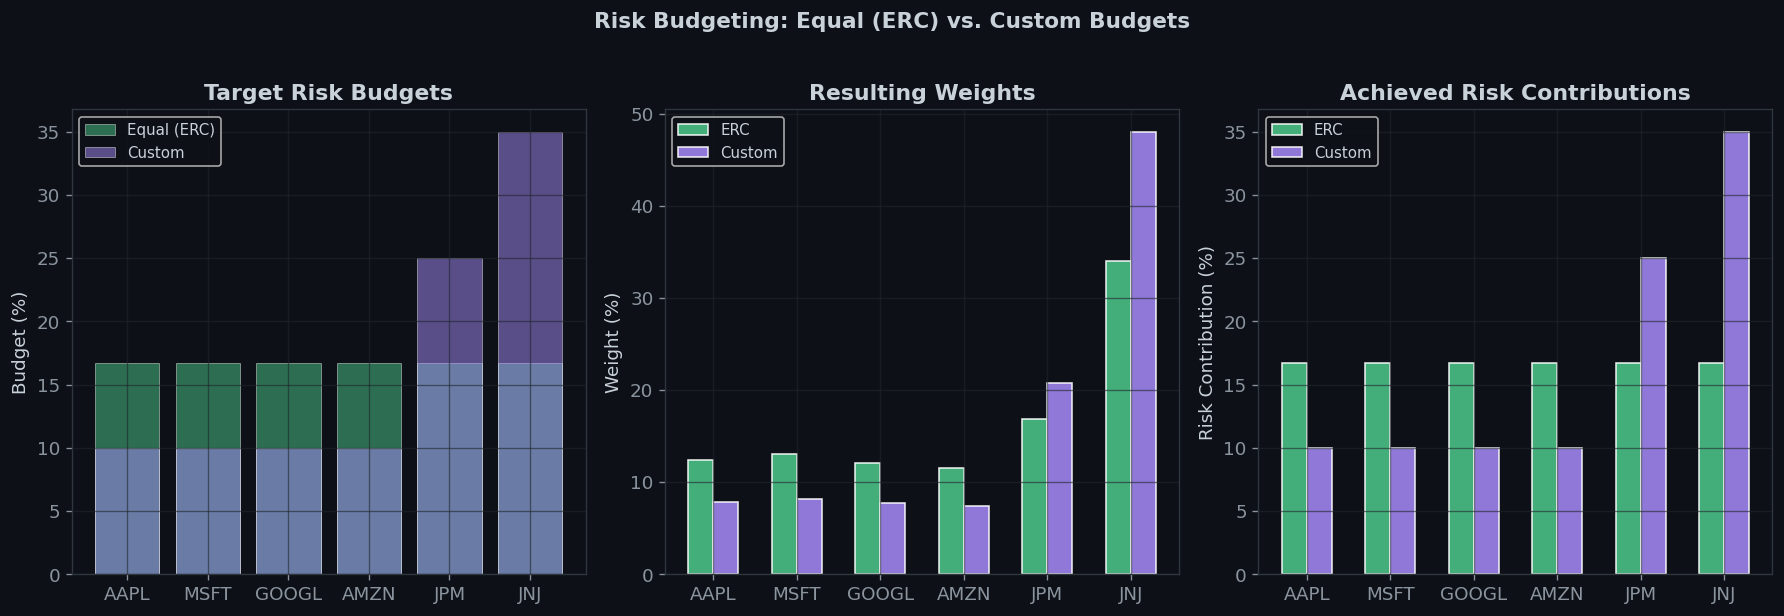

In [13]:
# ── Chart 7: Risk Budgeting — Custom vs. Equal Budgets ──
# Demonstrate the generalized risk budgeting framework

# Custom budget: overweight low-vol assets' risk contribution
custom_budget = np.array([0.10, 0.10, 0.10, 0.10, 0.25, 0.35])  # tilt toward JPM, JNJ
custom_budget = custom_budget / custom_budget.sum()

w_rb_custom = risk_parity_convex(Sigma_yf, budgets=custom_budget)

# Compare
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Budgets
axes[0].bar(tickers, np.ones(n_yf)/n_yf * 100, alpha=0.5, color=C_GREEN,
            label='Equal (ERC)', edgecolor='white', linewidth=0.5)
axes[0].bar(tickers, custom_budget * 100, alpha=0.5, color=C_PURPLE,
            label='Custom', edgecolor='white', linewidth=0.5)
axes[0].set_title('Target Risk Budgets', fontweight='bold')
axes[0].set_ylabel('Budget (%)')
axes[0].legend(fontsize=9)

# Resulting weights
axes[1].bar(np.arange(n_yf) - 0.15, w_rp_yf * 100, 0.3, label='ERC',
            color=C_GREEN, alpha=0.85, edgecolor='white')
axes[1].bar(np.arange(n_yf) + 0.15, w_rb_custom * 100, 0.3, label='Custom',
            color=C_PURPLE, alpha=0.85, edgecolor='white')
axes[1].set_xticks(np.arange(n_yf))
axes[1].set_xticklabels(tickers)
axes[1].set_title('Resulting Weights', fontweight='bold')
axes[1].set_ylabel('Weight (%)')
axes[1].legend(fontsize=9)

# Achieved risk contributions
_, _, prc_erc = risk_contributions(w_rp_yf, Sigma_yf)
_, _, prc_custom = risk_contributions(w_rb_custom, Sigma_yf)
axes[2].bar(np.arange(n_yf) - 0.15, prc_erc * 100, 0.3, label='ERC',
            color=C_GREEN, alpha=0.85, edgecolor='white')
axes[2].bar(np.arange(n_yf) + 0.15, prc_custom * 100, 0.3, label='Custom',
            color=C_PURPLE, alpha=0.85, edgecolor='white')
axes[2].set_xticks(np.arange(n_yf))
axes[2].set_xticklabels(tickers)
axes[2].set_title('Achieved Risk Contributions', fontweight='bold')
axes[2].set_ylabel('Risk Contribution (%)')
axes[2].legend(fontsize=9)

plt.suptitle('Risk Budgeting: Equal (ERC) vs. Custom Budgets',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

<a id='8'></a>
## 8. Comparison & Discussion

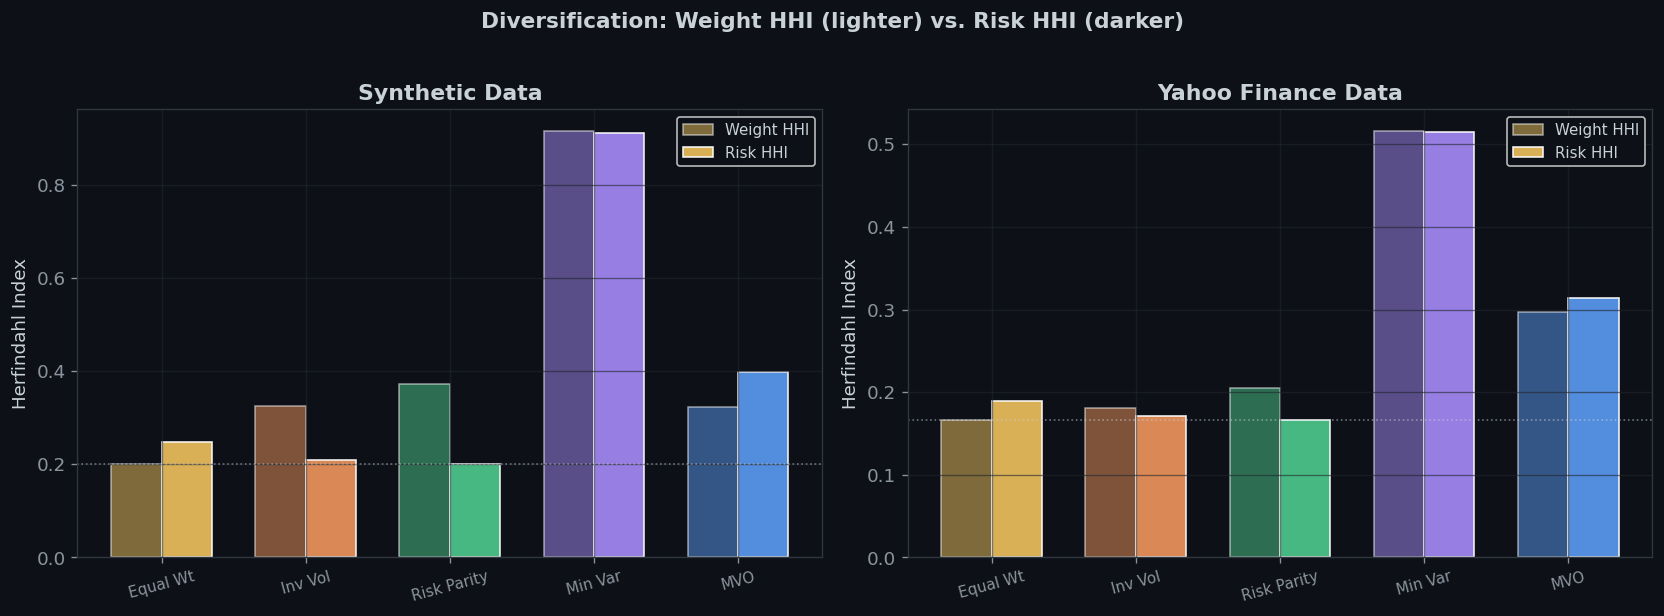

Risk Parity achieves the lowest Risk HHI by construction (exactly 1/n).
Equal Weight has the lowest Weight HHI, but concentrated risk.
MVO and Min Var tend to concentrate both weight and risk.


In [14]:
# ── Chart 8: Herfindahl Index of Risk Contributions ──
# HHI measures concentration — lower = more diversified

def hhi_risk(w, Sigma):
    """Herfindahl index of percentage risk contributions."""
    _, _, prc = risk_contributions(w, Sigma)
    return np.sum(prc ** 2)

def hhi_weight(w):
    """Herfindahl index of portfolio weights."""
    return np.sum(w ** 2)

labels_all = ['Equal Wt', 'Inv Vol', 'Risk Parity', 'Min Var', 'MVO']
colors_all = [C_YELLOW, C_ORANGE, C_GREEN, C_PURPLE, C_BLUE]

# Synthetic data
hhi_w_synth = [hhi_weight(w) for w in [w_eq, w_iv, w_rp, w_mv, w_mvo]]
hhi_r_synth = [hhi_risk(w, Sigma) for w in [w_eq, w_iv, w_rp, w_mv, w_mvo]]

# YF data
hhi_w_yf = [hhi_weight(w) for w in [w_eq_yf, w_iv_yf, w_rp_yf, w_mv_yf, w_mvo_yf]]
hhi_r_yf = [hhi_risk(w, Sigma_yf) for w in [w_eq_yf, w_iv_yf, w_rp_yf, w_mv_yf, w_mvo_yf]]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_hhi = np.arange(len(labels_all))
w_bar = 0.35

# Synthetic
axes[0].bar(x_hhi - w_bar/2, hhi_w_synth, w_bar, color=colors_all, alpha=0.5,
            edgecolor='white', label='Weight HHI')
axes[0].bar(x_hhi + w_bar/2, hhi_r_synth, w_bar, color=colors_all, alpha=0.9,
            edgecolor='white', label='Risk HHI')
axes[0].set_xticks(x_hhi)
axes[0].set_xticklabels(labels_all, fontsize=9, rotation=15)
axes[0].set_title('Synthetic Data', fontweight='bold')
axes[0].set_ylabel('Herfindahl Index')
axes[0].axhline(1/n, color='#c9d1d9', linewidth=1, linestyle=':', alpha=0.5)
axes[0].legend(fontsize=9, framealpha=0.9)

# YF
axes[1].bar(x_hhi - w_bar/2, hhi_w_yf, w_bar, color=colors_all, alpha=0.5,
            edgecolor='white', label='Weight HHI')
axes[1].bar(x_hhi + w_bar/2, hhi_r_yf, w_bar, color=colors_all, alpha=0.9,
            edgecolor='white', label='Risk HHI')
axes[1].set_xticks(x_hhi)
axes[1].set_xticklabels(labels_all, fontsize=9, rotation=15)
axes[1].set_title('Yahoo Finance Data', fontweight='bold')
axes[1].set_ylabel('Herfindahl Index')
axes[1].axhline(1/n_yf, color='#c9d1d9', linewidth=1, linestyle=':', alpha=0.5)
axes[1].legend(fontsize=9, framealpha=0.9)

plt.suptitle('Diversification: Weight HHI (lighter) vs. Risk HHI (darker)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('Risk Parity achieves the lowest Risk HHI by construction (exactly 1/n).')
print('Equal Weight has the lowest Weight HHI, but concentrated risk.')
print('MVO and Min Var tend to concentrate both weight and risk.')

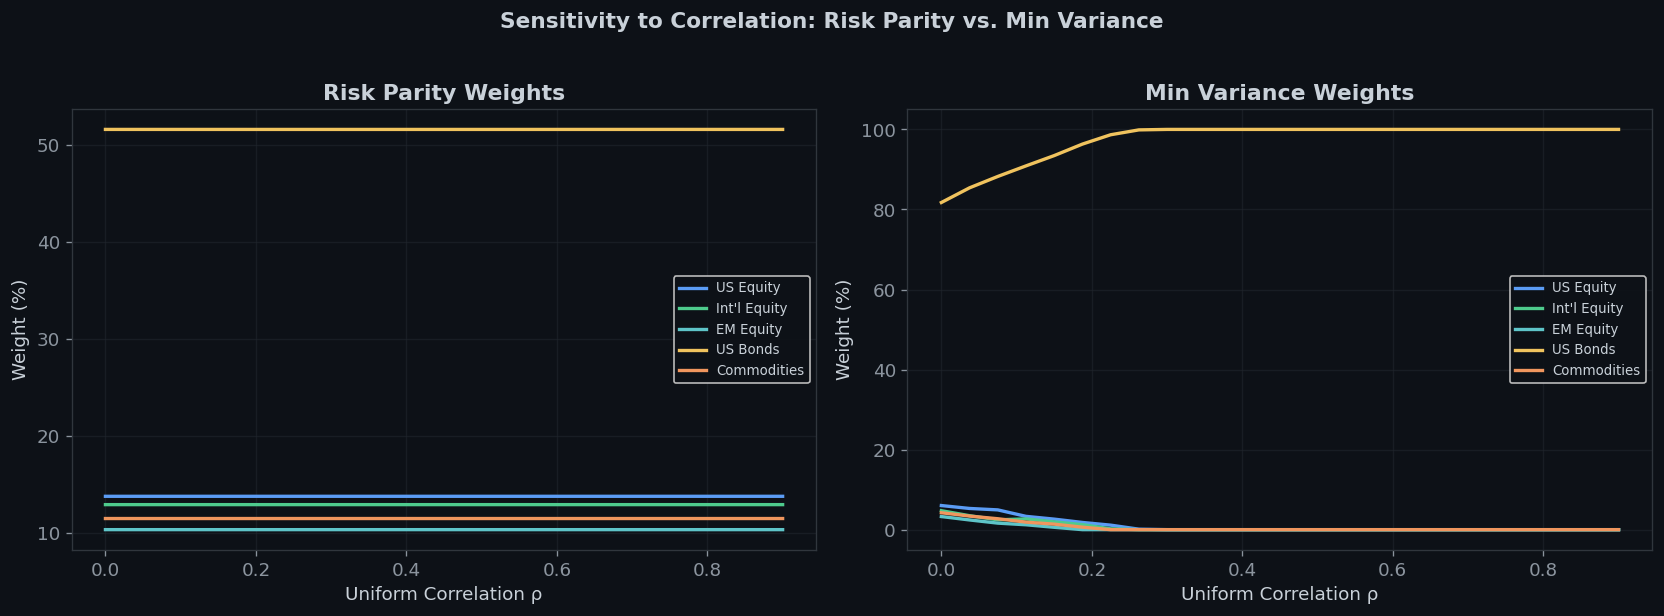

Risk parity weights are remarkably stable across correlation regimes.
Min variance weights shift dramatically as correlations change.


In [15]:
# ── Chart 9: Sensitivity to Correlation Changes ──
# Show how RP weights change as correlations increase (all assets become more correlated)

rho_range = np.linspace(0.0, 0.9, 25)
rp_weights_by_rho = []
mv_weights_by_rho = []

for rho in rho_range:
    # Build correlation matrix with uniform off-diagonal rho
    C = np.full((n, n), rho)
    np.fill_diagonal(C, 1.0)
    S = np.outer(vols, vols) * C
    
    # Ensure positive definite
    eigvals = np.linalg.eigvalsh(S)
    if eigvals.min() < 0:
        S += (-eigvals.min() + 1e-6) * np.eye(n)
    
    w_rp_rho = risk_parity_convex(S)
    w_mv_rho = min_variance(S)
    rp_weights_by_rho.append(w_rp_rho)
    mv_weights_by_rho.append(w_mv_rho)

rp_weights_by_rho = np.array(rp_weights_by_rho)
mv_weights_by_rho = np.array(mv_weights_by_rho)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

asset_colors = [C_BLUE, C_GREEN, C_TEAL, C_YELLOW, C_ORANGE]

for i, a in enumerate(assets):
    axes[0].plot(rho_range, rp_weights_by_rho[:, i] * 100, linewidth=2,
                 color=asset_colors[i], label=a)
    axes[1].plot(rho_range, mv_weights_by_rho[:, i] * 100, linewidth=2,
                 color=asset_colors[i], label=a)

axes[0].set_title('Risk Parity Weights', fontweight='bold')
axes[0].set_xlabel('Uniform Correlation ρ')
axes[0].set_ylabel('Weight (%)')
axes[0].legend(fontsize=8, framealpha=0.9)

axes[1].set_title('Min Variance Weights', fontweight='bold')
axes[1].set_xlabel('Uniform Correlation ρ')
axes[1].set_ylabel('Weight (%)')
axes[1].legend(fontsize=8, framealpha=0.9)

plt.suptitle('Sensitivity to Correlation: Risk Parity vs. Min Variance',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('Risk parity weights are remarkably stable across correlation regimes.')
print('Min variance weights shift dramatically as correlations change.')

### Key Takeaways

**Risk parity achieves exactly equal risk contributions**, which no other standard portfolio strategy does. Equal weighting produces equal capital allocation but highly unequal risk; minimum variance concentrates in the lowest-risk assets; and MVO is dominated by estimation error in expected returns.

**Risk parity weights are remarkably stable** across different correlation regimes. When all correlations are equal, the inverse-volatility portfolio coincides with the ERC portfolio. As correlations become heterogeneous, the full ERC optimization adjusts weights to account for diversification benefits — assets that are less correlated with the rest receive higher weights.

**The risk budgeting framework is flexible.** By changing the target budgets $b_i$, investors can express views on relative risk importance while maintaining the disciplined risk-allocation philosophy. This bridges the gap between pure risk parity and active management.

**When is risk parity most useful?** When the investor does not have reliable return forecasts, when tail-risk protection is important, when the asset universe spans dramatically different volatility levels (e.g., stocks, bonds, commodities), and when robustness to estimation error is valued over aggressive return-seeking.

<a id='9'></a>
## 9. References

**[1]** Qian, E. (2005). "Risk Parity Portfolios: Efficient Portfolios Through True Diversification." PanAgora Asset Management.

**[2]** Qian, E. (2006). "On the Financial Interpretation of Risk Contribution: Risk Budgets Do Add Up." *Journal of Investment Management*, 4(4).

**[3]** Maillard, S., Roncalli, T. and Teiletche, J. (2010). "The Properties of Equally Weighted Risk Contribution Portfolios." *Journal of Portfolio Management*, 36(4), pp. 60–70.

**[4]** Roncalli, T. (2013). *Introduction to Risk Parity and Budgeting*. Chapman & Hall/CRC.

**[5]** Spinu, F. (2013). "An Algorithm for Computing Risk Parity Weights." *SSRN Working Paper*.

**[6]** Griveau-Billion, T., Richard, J.-C. and Roncalli, T. (2013). "A Fast Algorithm for Computing High-Dimensional Risk Parity Portfolios." *SSRN Working Paper*.

**[7]** Bruder, B. and Roncalli, T. (2012). "Managing Risk Exposures Using the Risk Budgeting Approach." *SSRN Working Paper*.

**[8]** Asness, C., Frazzini, A. and Pedersen, L. (2012). "Leverage Aversion and Risk Parity." *Financial Analysts Journal*, 68(1), pp. 47–59.

**[9]** Chaves, D., Hsu, J., Li, F. and Shakernia, O. (2011). "Risk Parity Portfolio vs. Other Asset Allocation Heuristic Portfolios." *Journal of Investing*, 20(1), pp. 108–118.

**[10]** Chaves, D., Hsu, J., Li, F. and Shakernia, O. (2012). "Efficient Algorithms for Computing Risk Parity Portfolio Weights." *Journal of Investing*, 21(3), pp. 150–163.

**[11]** Markowitz, H.M. (1952). "Portfolio Selection." *The Journal of Finance*, 7(1), pp. 77–91.

**[12]** Merton, R.C. (1980). "On Estimating the Expected Return on the Market: An Exploratory Investigation." *Journal of Financial Economics*, 8(4), pp. 323–361.

**[13]** Best, M.J. and Grauer, R.R. (1991). "On the Sensitivity of Mean-Variance-Efficient Portfolios to Changes in Asset Means." *The Review of Financial Studies*, 4(2), pp. 315–342.

**[14]** Michaud, R.O. (1989). "The Markowitz Optimization Enigma: Is 'Optimized' Optimal?" *Financial Analysts Journal*, 45(1), pp. 31–42.

**[15]** Qian, E. (2016). *Risk Parity Fundamentals*. CRC Press.

**[16]** Feng, Y. and Palomar, D.P. (2015). "SCRIP: Successive Convex Optimization Methods for Risk Parity Portfolio Design." *IEEE Transactions on Signal Processing*, 63(19), pp. 5285–5300.

**[17]** Ledoit, O. and Wolf, M. (2004). "A Well-Conditioned Estimator for Large-Dimensional Covariance Matrices." *Journal of Multivariate Analysis*, 88(2), pp. 365–411.

**[18]** Bai, X., Scheinberg, K. and Tutuncu, R. (2016). "Least-Squares Approach to Risk Parity in Portfolio Selection." *Quantitative Finance*, 16(3), pp. 357–376.

---